In [4]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import gc
gc.collect()

0

# Project: Image Classification with TensorFlow

### Objective
This project focuses on building a series of models to classify a series of images into one of ten classes. These images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.

### Data
CIFAR-10 data set will be used in the project. 
* Size: 60,000 images, (Train: 50,000, Test: 10,000)
* The image is in 32×32  color pixels, each belongs to one of the Ten classes
* Data are in NumPy's .npy format.

### Classification models

1. Smallest Delta Model
2. Fully-connected NN model
3. Convolutional NN model
4. Transfer learning NN model

### Model validation

The validation of this project is using a set of reference models to score the test data accuracy. 
**The accuracy of model prediction = Score * reference model accuracy**

Reference model accuracy:
Smallest Delta Model: reference solution achieves an accuracy of about 44% on a training set and 41% on a test set. 
Fully-connected NN model： train set - 44% on a test set - 41%
Convolutional NN model:  train set - 80% on a test set - 70%
Transfer learning NN model:  train set - 87% on a test set - 85%


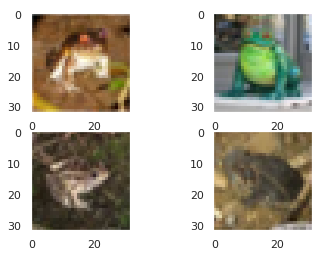

In [7]:
frogs = np.where(train_labels == 6)[0]   #  Get the indices for the frogs

fig, ax = matplotlib.pyplot.subplots(2, 2)
for i in range(4):
    np.ravel(ax)[i].imshow(train_images[ frogs[i] ])

matplotlib.pyplot.show()

## Access the data

In [8]:
!aws s3 sync s3://dataincubator-course/cifar10/ .

In [6]:
import numpy as np

train_images = np.load(open('train_images.npy', 'rb'))
train_labels = np.load(open('train_labels.npy', 'rb'))
validation_images = np.load(open('validation_images.npy', 'rb'))

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

The human-readable names associated with this classes are

In [5]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [170]:
train_labels.shape, train_images.shape,validation_images.shape

((50000,), (50000, 32, 32, 3), (10000, 32, 32, 3))

## TensorFlow resets

The cell below includes the same reset code we use in the rest of module.

In [7]:
import tensorflow as tf

sess = None

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

def reset_vars():
    sess.run(tf.global_variables_initializer())
    
reset_tf()

## Analysis

### 1. Perceptual RGB distance model

To start with a simple model, since we have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  A simplified metric to determine the distance between two images.  is the **average difference between the colors of the corresponding pixels** in the two images.


$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.


#### Delta function

Define the TensorFlow placeholders `images` and `base` that will contain, respectively, a set of images and a single image. 

Use Use the `delta_func` to define a graph that takes a series of images and a base image and returns the distance (the average $\Delta C$ value) between the base image and each image in the series. 

For two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).  

In [7]:
def delta_func(images, base): ## base is a tf.placeholder
    
    d_r = images[:,:,:,0] - base[:,:,0]
    d_g = images[:,:,:,1] - base[:,:,1]
    d_b = images[:,:,:,2] - base[:,:,2]
    mean_r = 1/2 * (images[:,:,:,0] + base[:,:,0])
    d_c = tf.sqrt(2*d_r**2 + 4*d_g**2 + 3*d_b**2 + mean_r*(d_r**2 - d_b**2))
    
    return d_c ## return a tensor

In [8]:
def delta_func_np(images, base): ## input all image matrix
    
    d_r = images[:,:,:,0] - base[:,:,0]
    d_g = images[:,:,:,1] - base[:,:,1]
    d_b = images[:,:,:,2] - base[:,:,2]
    mean_r = 1/2 * (images[:,:,:,0] + base[:,:,0])
    d_c = np.sqrt(2*d_r**2 + 4*d_g**2 + 3*d_b**2 + mean_r*(d_r**2 - d_b**2))
    
    return d_c ## return a numpy array

#### Smallest delta model

**Problem**
A "typical" image was generated for each class.  This typical image will be the one that minimizes the total (or average) perceptual delta from all training images in this class.  As a minimization problem, gradient descent was used.  

* First Step: train a typical image for each class in the training set
* Second Step: Make predictions on the validation set. These predictions will be based on the closest "typical" image trained in the first step.

**Method**

* The typical image for each class was made as a TensorFlow variable, starting with random pixel values.  
* Define an error function that measures the difference between that typical image and a set of images. 
* Performing gradient descent to train the typical image.

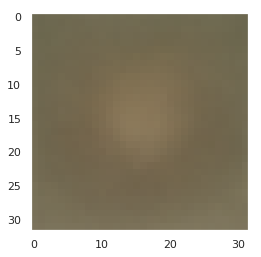

In [9]:
## Example of a typical image (classification: frog)
matplotlib.pyplot.imshow(np.load('typical_6.npy'))

Performing a batched version of __stochastic gradient descent__.  since the training set consists of 5,000 images


In [170]:
typical_image = []
typical = tf.Variable(tf.random_normal([32, 32, 3], mean = 0, stddev=0.5),name="typical")

x = tf.placeholder(dtype=tf.float32, shape=(None,32, 32, 3))

init = tf.initializers.global_variables()

for i in range(10):

    sess.run(init)

    x_train = train_images[train_labels==i]
    error = tf.reduce_mean(delta_func(x_train,typical))

    optimizer = tf.train.GradientDescentOptimizer(0.5)
    train = optimizer.minimize(error)

    batch_size = 100
    steps_total = 4000

    for i in range(steps_total):
        j = np.random.choice(len(x_train), batch_size, replace=False)

        x_batch = x_train[j,:]

        sess.run(train, feed_dict={x: x_batch})

    typical_image.append(sess.run(typical))


In [178]:
np.save('typical_image.npy',typical_image)

In [11]:
typical_image = np.load(open('typical_image.npy', 'rb'))

In [39]:
test_dist = np.zeros([10000,10])
for i in range(len(typical_image)):
    test_dist[:,i] = np.nansum(delta_func_np(validation_images,typical_image[i]),axis=(1,2))

In [10]:
test_dist = np.load(open('test_dist.npy', 'rb'))

In [39]:
delta_pred = list(np.argmin(test_dist,axis=1))

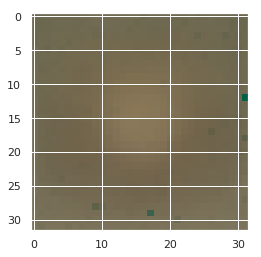

In [11]:
matplotlib.pyplot.imshow(typical_image[6].clip(min=0,max=1))

In [47]:
from static_grader import grader

In [48]:
grader.score('tf__smallest_delta', list(np.argmin(test_dist,axis=1)))

Your score:  1.0042849491162291


### 2. Fully-connected model

The previous model still makes the assumption that this distance metric is the right measure to use.  In this problem, we'll give this up.  Build a multi-layer fully-connected neural network that takes the pixel values as input and yields a class prediction as output.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for over-fitting.  Drop-out can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [123]:
X_train, y_train = train_images,train_labels
X_test = validation_images

In [125]:
N_PIXELS= 32 * 32 * 3
N_CLASSES = 10

hidden_size = 64

In [156]:
reset_tf()

x = tf.placeholder(tf.float32, [None, 32,32,3], name="pixels")

x_input = tf.reshape(x,[-1,3072])
y_label = tf.placeholder(tf.int64, [None,], name="labels")

W1 = tf.Variable(initializer([N_PIXELS, hidden_size]), name="weights")
b1 = tf.Variable(tf.zeros([hidden_size]), name="biases")

hidden = tf.nn.sigmoid(tf.matmul(x_input, W1) + b1)

W2 = tf.Variable(initializer([hidden_size, N_CLASSES]), name="weights2")
b2 = tf.Variable(tf.zeros([N_CLASSES]), name="biases2")

y = tf.matmul(hidden, W2) + b2

softmax = tf.nn.softmax_cross_entropy_with_logits_v2
loss = tf.reduce_mean(softmax(logits=y, 
                              labels=tf.one_hot(y_label, 10)))
train = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), y_label), tf.float32))

batch_size  = 30
steps_total = 10000
steps_print = 1000

reset_vars()

for i in range(steps_total):
    j = np.random.choice(len(y_train), batch_size, replace=False)
    x_batch, y_batch = X_train[j,:], y_train[j]
    
    sess.run(train, feed_dict={x: x_batch, 
                               y_label: y_batch})
    
    if i % steps_print == 0 or i == steps_total - 1:
#         l, a = sess.run([loss, accuracy], feed_dict={x: X_test,
#                                                      y_label: y_test})
#         print("Test:  %0.5f, %0.5f   at step %05i" % (l, a, i))
        l, a = sess.run([loss, accuracy], feed_dict={x: X_train,
                                                     y_label: y_train})
        print("Train: %0.5f, %0.5f   at step %05i" % (l, a, i))

Train: 2.34145, 0.10000   at step 00000
Train: 1.85630, 0.33560   at step 01000
Train: 1.75656, 0.37274   at step 02000
Train: 1.72151, 0.38252   at step 03000
Train: 1.66950, 0.40328   at step 04000
Train: 1.64761, 0.40578   at step 05000
Train: 1.56958, 0.44196   at step 06000
Train: 1.55093, 0.44794   at step 07000
Train: 1.54313, 0.45420   at step 08000
Train: 1.54331, 0.44906   at step 09000
Train: 1.48483, 0.46988   at step 09999


In [159]:
y_test = sess.run(y,feed_dict = {x:X_test})

In [166]:
np.argmax(y_test,axis=1)

array([5, 0, 2, ..., 9, 4, 3])

In [168]:
grader.score('tf__fully_connected', list(np.argmax(y_test,axis=1)))

Your score:  1.1135152085293196


### 3. Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

**Note:**
- The solution used three convolutional layers and two fully-connected layers.
- The solution used the `AdamOptimizer`.
- A solution with an accuracy of 80% on a training set and 70% on a test set was regarded as a reference. The grading score > 1 indicates the test accuracy is higher than 70%

In [108]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot

In [268]:
X_train = train_images
y_train = one_hot(train_labels)
X_test = validation_images

In [269]:
X_train.shape,y_train.shape,X_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3))

In [272]:
N_PIXELS= 32 * 32 * 3
N_CLASSES = 10
hidden_size = 64

In [298]:
# Model parameters
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 3
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 50
n_epochs = 5

In [306]:
model = keras.models.Sequential()

## reshape layer

model.add(keras.layers.Reshape([img_size, img_size, 3]))

## convolution layer 1
model.add(keras.layers.Conv2D(16, filt_size, padding='same',
                            activation='relu'))
## followed by a max pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))
## convolution layer 2
model.add(keras.layers.Conv2D(32, filt_size, padding='same',
                              activation='relu'))
## followed by a max pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

## convolution layer 3
model.add(keras.layers.Conv2D(64, filt_size, padding='same',
                              activation='relu'))
## followed by a max pooling
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

## flatten layer
model.add(keras.layers.Flatten())

## full-connected layer 1
model.add(keras.layers.Dense(100, activation='relu'))

## full-connected layer 2
model.add(keras.layers.Dense(100, activation='relu'))

## output layer
model.add(keras.layers.Dense(N_CLASSES, activation='softmax'))

In [309]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 45s 900us/step - loss: 1.4985 - acc: 0.4522 - val_loss: 1.2772 - val_acc: 0.5921
Epoch 2/5
50000/50000 [==============================] - 45s 891us/step - loss: 1.0827 - acc: 0.6159 - val_loss: 1.2030 - val_acc: 0.6424
Epoch 3/5
50000/50000 [==============================] - 44s 888us/step - loss: 0.9145 - acc: 0.6790 - val_loss: 1.2346 - val_acc: 0.6432
Epoch 4/5
50000/50000 [==============================] - 44s 872us/step - loss: 0.7957 - acc: 0.7207 - val_loss: 1.2090 - val_acc: 0.6849
Epoch 5/5
50000/50000 [==============================] - 44s 889us/step - loss: 0.7111 - acc: 0.7512 - val_loss: 1.2327 - val_acc: 0.6774


In [ ]:
def predict(x):
    return np.argmax(model.predict(x)) 

In [310]:
y_test = model.predict(X_test)

In [311]:
y_test = model.predict(X_test)
np.argmax(y_test,axis=1)

array([7, 7, 5, ..., 9, 4, 3])

In [312]:
# predicted_classes = return [0]*len(validation_images)

grader.score('tf__convolutional', list(np.argmax(y_test,axis=1)))

Your score:  0.9729335494327391


### 4. Transfer learning

In transfer learning, we use the `GoogLeNet` network to process the image to latent vectors, and use the latent vectors to train the model.

Use the first part of the **GoogLeNet** trained network to process the original images, and then train a network to make predictions from the output of the trained network.  

* One approach to accomplish this is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

* Another approach can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions. ** This approach is used in the analysis**

In [35]:
import os
from urllib.request import urlopen
import zipfile

data_url = "http://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip"
data_dir = os.path.expanduser("~/inception/5h/")
file_path = os.path.join(data_dir, 'inception5h.zip')

if not os.path.exists(file_path):
    # Check if the download directory exists, otherwise create it.
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    # Download
    with open(file_path, "wb") as local_file:
        local_file.write(urlopen(data_url).read())
    # Extract
    zipfile.ZipFile(file_path, mode="r").extractall(data_dir)

path = os.path.join(data_dir, "tensorflow_inception_graph.pb")
with tf.gfile.FastGFile(path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [12]:
type(graph_def)

tensorflow.core.framework.graph_pb2.GraphDef

In [36]:
import scipy as sc
import numpy as np
import datetime as dt

In [38]:
googlenet_input = sess.graph.get_tensor_by_name("input:0")
googlenet_input

<tf.Tensor 'input:0' shape=<unknown> dtype=float32>

In [39]:
layer_mixed5b =  sess.graph.get_tensor_by_name("mixed5b:0")
layer_mixed5b

<tf.Tensor 'mixed5b:0' shape=(?, ?, ?, 1024) dtype=float32>

In [40]:
layer_avgpool0 =  sess.graph.get_tensor_by_name("avgpool0:0")
layer_avgpool0

<tf.Tensor 'avgpool0:0' shape=(?, ?, ?, 1024) dtype=float32>

In [ ]:
## Function to transform the image to latent vector
def latent_transform(input_tensor, output_tensor, images, batch_size):
    
    steps  = len(images)//batch_size
    latent = np.zeros([len(images), 1, 1, 1024])
    
    for i in range(steps):
    
    x_batch = images[batch_size*i:batch_size*i+batch_size,:]

    latent_batch = sess.run(output_tensor, {input_tensor: sc.ndimage.zoom((x_batch),(1,7,7,1),order=1)}) #*255
    latent[batch_size*i:batch_size*i+batch_size,:] = latent_batch
    
    return latent    

In [151]:
## Batch transfer train images to latent vectors
batch_size = 50
steps_total  = len(train_images)//batch_size
latent_vec = np.zeros([len(train_images), 1, 1, 1024])
for i in range(steps_total):
    
    x_batch = train_images[batch_size*i:batch_size*i+batch_size,:]

    latent_batch = sess.run(layer_avgpool0, {googlenet_input: sc.ndimage.zoom((x_batch*255),(1,7,7,1),order=1)})
    latent_vec[batch_size*i:batch_size*i+batch_size,:] = latent_batch

In [153]:
## Batch transfer test images to latent vectors
batch_size = 50
steps_total  = len(validation_images)//batch_size
latent_vec_test = np.zeros([len(validation_images), 1, 1, 1024])
for i in range(steps_total):
    
    x_batch = validation_images[batch_size*i:batch_size*i+batch_size,:]

    latent_batch = sess.run(layer_avgpool0, {googlenet_input: sc.ndimage.zoom((x_batch*255),(1,7,7,1),order=1)}) #
    latent_vec_test[batch_size*i:batch_size*i+batch_size,:] = latent_batch

In [154]:
latent_vec_test.shape

(10000, 1, 1, 1024)

In [155]:
np.save('latent_vec.npy',latent_vec)
np.save('latent_vec_test.npy',latent_vec_test)

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Notes:**
- The solution has three layers.
- The solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [156]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical as one_hot

In [157]:
X_train = latent_vec
y_train = one_hot(train_labels)
X_test = latent_vec_test

In [158]:
X_train.shape,y_train.shape,X_test.shape

((50000, 1, 1, 1024), (50000, 10), (10000, 1, 1, 1024))

In [160]:
# Model parameters
N_CLASSES = 10
batch_size = 50
n_epochs = 80

In [161]:
model = keras.models.Sequential()

In [162]:
## flatten layer
model.add(keras.layers.Flatten())

## full-connected layer 1
model.add(keras.layers.Dense(128, activation='relu'))

## full-connected layer 2
model.add(keras.layers.Dense(128, activation='relu'))

## full-connected layer 3
model.add(keras.layers.Dense(64, activation='relu'))

## output layer
model.add(keras.layers.Dense(N_CLASSES, activation='softmax'))

In [164]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size
                    )

Epoch 1/80
50000/50000 [==============================] - 6s 129us/step - loss: 0.7004 - acc: 0.7584
Epoch 2/80
50000/50000 [==============================] - 6s 128us/step - loss: 0.4656 - acc: 0.8385
Epoch 3/80
50000/50000 [==============================] - 7s 131us/step - loss: 0.4109 - acc: 0.8567
Epoch 4/80
50000/50000 [==============================] - 6s 128us/step - loss: 0.3735 - acc: 0.8688
Epoch 5/80
50000/50000 [==============================] - 6s 126us/step - loss: 0.3416 - acc: 0.8808
Epoch 6/80
50000/50000 [==============================] - 6s 126us/step - loss: 0.3122 - acc: 0.8913
Epoch 7/80
50000/50000 [==============================] - 6s 129us/step - loss: 0.2847 - acc: 0.9008
Epoch 8/80
50000/50000 [==============================] - 6s 130us/step - loss: 0.2634 - acc: 0.9082
Epoch 9/80
50000/50000 [==============================] - 6s 125us/step - loss: 0.2395 - acc: 0.9163
Epoch 10/80
50000/50000 [==============================] - 6s 122us/step - loss: 0.2213 - a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [165]:
y_test = model.predict(X_test)

In [166]:
np.argmax(y_test,axis=1)

array([7, 9, 3, ..., 9, 4, 5])

In [167]:
# predicted_classes = return [0]*len(validation_images)

grader.score('tf__transfer_learning', list(np.argmax(y_test,axis=1)))

Your score:  1.0015934138892577


*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*